In [164]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from IPython.display import Latex
from datetime import datetime

import nbimporter
import spin_func as myfunc
from importlib import reload
reload(myfunc)

<module 'spin_func' from 'spin_func.ipynb'>

In [165]:
m = 1; n = 1; B = [0, 0, 1.8]; A = [[114]]; # MHz
H_zn = Qobj(myfunc.z_hamiltonian(m, 0, B)) # Hz
H_ze = Qobj(np.kron(np.eye(2**m), myfunc.z_hamiltonian(0, n, B)))
H_hf = Qobj(myfunc.hf_hamiltonian(m, n, A))

H_neut = Qobj(np.kron(H_zn, np.eye(2**n)))+H_ze+H_hf
H_ion = H_zn

spinProj = Qobj(np.kron(np.eye(2**m), np.eye(2**n+1)[0:2**n]))
setProj = Qobj(np.kron(np.eye(2**m), np.eye(2**n+1)[-1]))

H = Qobj(spinProj.dag()*H_neut*spinProj+setProj.dag()*H_ion*setProj)
H_new = Qobj(np.diag(H.eigenstates()[0]))
evecs = H.eigenstates()[1]

In [166]:
############################
### Projection Operators ###
############################

basisT = Qobj(np.concatenate(([np.array(evecs[i]) for i in range(len(evecs))]), axis = 1))

state0 = Qobj(np.kron(fock_dm(2**m, 0), np.eye(2**n+1)))
state1 = Qobj(np.kron(fock_dm(2**m, 1), np.eye(2**n+1)))

electron_up = Qobj(np.kron(np.eye(2**(m)), fock_dm(2**n+1, 0)))
electron_down = Qobj(np.kron(np.eye(2**(m)), fock_dm(2**n+1, 1)))
electron_set = Qobj(np.kron(np.eye(2**(m)), fock_dm(2**n+1, 2)))

### Expressed in Eigenbasis ###

state0  = basisT.dag()*state0*basisT
state1  = basisT.dag()*state1*basisT

electron_up = basisT.dag()*electron_up*basisT
electron_down = basisT.dag()*electron_down*basisT
electron_set = basisT.dag()*electron_set*basisT

In [167]:
############################
### Tunneling Operators ####
############################

set2down = basisT.dag()*Qobj(np.kron(np.eye(2**m), fock(3, 1)*fock(3, 2).dag()))*basisT
set2up = basisT.dag()*Qobj(np.kron(np.eye(2**m), fock(3, 0)*fock(3, 2).dag()))*basisT

### Read ###

tauRead_up_out = 300e-6
tauRead_down_in = 30e-6

Lread_down_in = np.sqrt(1/tauRead_down_in)*set2down
Lread = myfunc.outOp(m, evecs, [tauRead_up_out], 0)
Lread.append(Lread_down_in)

### RTS ###

tauRts_up_out = 50e-6
tauRts_down_out = 90e-6
tauRts_down_in = 50e-6

Lrts_down_in = np.sqrt(1/tauRts_down_in)*set2down
tauRts_out = [tauRts_up_out, tauRts_down_out] # tauEmpty[0] is for up electron, tauEmpty[1] is for down electron
Lrts = myfunc.outOp(m, evecs, tauRts_out, 1)
Lrts.append(Lrts_down_in)

In [168]:
Lread = liouvillian(2*np.pi*H_new, Lread)
Lres = liouvillian(2*np.pi*H_new, Lrts)

Tread = 1e-3
Tres = 8e-3
Tinit = 1e-3
dt = 5e-6
Nread = int(Tread/dt)
Nres = int(Tres/dt)
Ninit = int(Tinit/dt)
N = Nread+Nres+Ninit
t = np.arange(0, Tread+Tres+Tinit, dt)

rho_init = fock(6, 5)
rho_init = rho_init*rho_init.dag()
rho_vec = operator_to_vector(rho_init)

rho = []
for i in range(Nread):
    rho_vec = ((dt*Lread).expm())*rho_vec
    rho.append(vector_to_operator(rho_vec))
    
index = i+1
    
for i in range(index, index+Nres):
    rho_vec = ((dt*Lres).expm())*rho_vec
    rho.append(vector_to_operator(rho_vec))
    
index = i+1

for i in range(index, index+Nread):
    rho_vec = ((dt*Lread).expm())*rho_vec
    rho.append(vector_to_operator(rho_vec))
    
T = Tread+Tres+Tinit
rate = (1+Tres/(tauRts_down_out+tauRts_down_in))/T
Pu = np.real(expect(state0, rho))
Pd = np.real(expect(state1, rho))
eSpin_up = np.real(expect(electron_up, rho))
eSpin_down = np.real(expect(electron_down, rho))
eSET = np.real(expect(electron_set, rho))

print(Pd[-1]/T)
print(rate)

0.0149020017106338
5814.285714285713


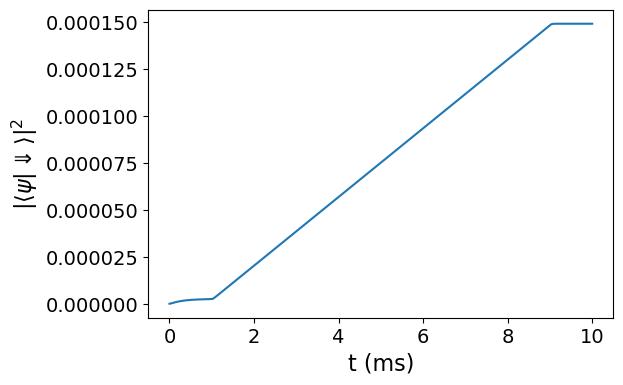

In [169]:
t = [1000*t[i] for i in range(N)]
plt.plot(t, Pd)
plt.ylabel('$|\\langle \psi | \\Downarrow \\rangle|^2$')
plt.xlabel('t (ms)')
plt.rcParams["figure.figsize"] = (6,4)

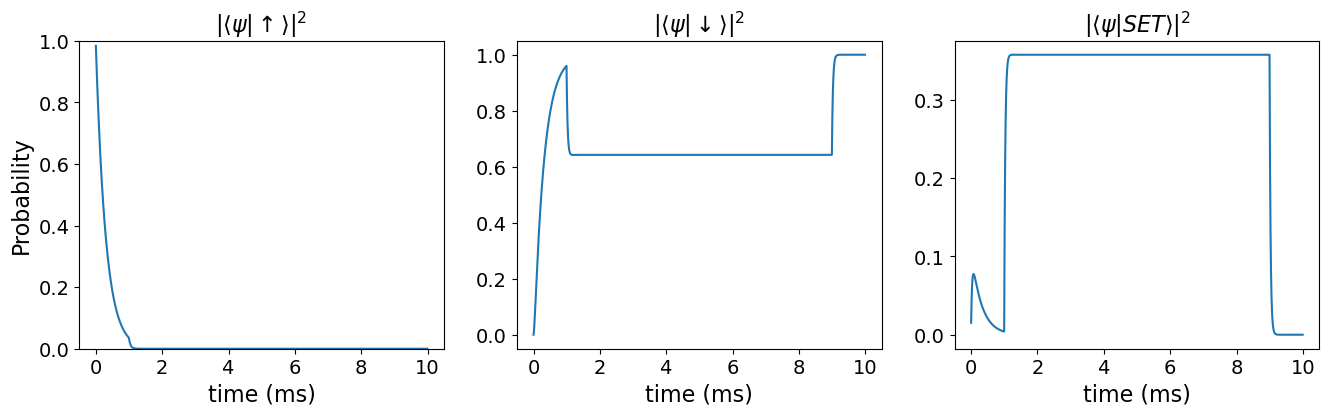

In [171]:
plt.subplot(1, 3, 2)
plt.plot(t, eSpin_down)
plt.title('$|\\langle \psi | \\downarrow \\rangle|^2$')
plt.xlabel('time (ms)')
#plt.ylabel('Probability')
plt.subplot(1, 3, 1)
plt.plot(t, eSpin_up)
plt.title('$|\\langle \psi | \\uparrow \\rangle|^2$')
plt.xlabel('time (ms)')
plt.ylabel('Probability')
plt.ylim([0, 1])
plt.subplot(1,3, 3)
plt.plot(t, eSET)
#plt.title('$|\\langle \psi | SET \\rangle|^2$')
plt.title('$|\\langle \psi | SET \\rangle|^2$')
plt.xlabel('time (ms)')
#plt.ylabel('Probability')
plt.rcParams["figure.figsize"] = (16, 4)

In [172]:
time_tunnel = [0, 0.0002, 0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.004, 0.006, 0.008]
rate_ionneutr = [(1+val/(tauRes_down_in+tauRes_down_out))/(0.002+val) for val in time_tunnel]

rate_flip = [0.001278, 0.002942, 0.004782, 0.007031, 0.008637, 0.009842,
             0.010759, 0.011529, 0.012653, 0.014059, 0.014902]

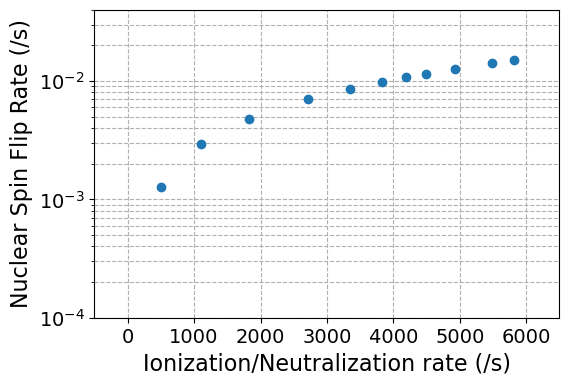

In [174]:
plt.plot(rate_ionneutr, rate_flip, 'o')
plt.yscale('log')
plt.xlim([-500, 6500])
plt.ylim([1e-4, 4e-2])
plt.xlabel("Ionization/Neutralization rate (/s)")
plt.ylabel("Nuclear Spin Flip Rate (/s)")
plt.grid(which='both', linestyle='--')
plt.rcParams["figure.figsize"] = (6,4)